In [170]:
import numpy as np
import scipy
from profilehooks import profile
from functools import cache
import matplotlib.pyplot as plt
from matplotlib import colors
import gurobipy as gp
from gurobipy import GRB
import json

In [25]:
rng = np.random.default_rng()

In [103]:
def gridshow(grid, truncations=[], log=True, thresh=-6):
    '''Display a grid of coefficients coloured by log values.'''

    # pre-processing
    grid = grid.squeeze()
    if log:
        grid = np.log10(grid)

    # color map of fixed colors
    cmap = colors.ListedColormap(['blue', 'yellow', 'red'])
    bounds=[-10, thresh, 1, 2]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # plot grid
    plt.imshow(grid, cmap=cmap, norm=norm)

    # truncation
    for truncation in truncations:
        # plot truncation lines
        plt.axhline(truncation['min_x1'], color=truncation['colour'], linewidth=2, label=truncation['label'])
        plt.axhline(truncation['max_x1'], color=truncation['colour'], linewidth=2)
        plt.axvline(truncation['min_x2'], color=truncation['colour'], linewidth=2)
        plt.axvline(truncation['max_x2'], color=truncation['colour'], linewidth=2)

    plt.colorbar()
    plt.show()

# Truncation Investigation

The 'B-matrix' constraint for each observed state $(x_{1}^{OB}, x_{2}^{OB})$ involves an infinite sum over the grid of $(x_{1}^{OG}, x_{2}^{OG})$ states.

To construct the constraint we need to truncate this sum to the region of OG states where the coefficients in the sum are above a threshold:

$$ B(x_{1}^{OB}, x_{2}^{OB}, x_{1}^{OG}, x_{2}^{OG}, \beta) \ge \epsilon = 10^{-6} $$

However, if $ \beta $ is a vector of $ n $, per cell, capture efficiencies then computing the coefficient involves a sum over each value:

\begin{align}
& B(x_{1}^{OB}, x_{2}^{OB}, x_{1}^{OG}, x_{2}^{OG}, \beta) \\
& = \frac{1}{n} \sum_{j=1}^{n} Bm(x_{1}^{OB}, x_{1}^{OG}, \beta_{j}) Bm(x_{2}^{OB}, x_{2}^{OG}, \beta_{j}) \\
& = \frac{1}{n} \sum_{j=1}^{n} \begin{pmatrix} x_{1}^{OG} \\ x_{1}^{OB} \end{pmatrix} \beta_{j}^{x_{1}^{OB}} (1 - \beta_{j})^{x_{1}^{OG} - x_{1}^{OB}} \begin{pmatrix} x_{2}^{OG} \\ x_{2}^{OB} \end{pmatrix} \beta_{j}^{x_{2}^{OB}} (1 - \beta_{j})^{x_{2}^{OG} - x_{2}^{OB}} \\
& = \frac{1}{n} \sum_{j=1}^{n} \begin{pmatrix} x_{1}^{OG} \\ x_{1}^{OB} \end{pmatrix} \begin{pmatrix} x_{2}^{OG} \\ x_{2}^{OB} \end{pmatrix} \beta_{j}^{x_{1}^{OB} + x_{2}^{OB}} (1 - \beta_{j})^{x_{1}^{OG} + x_{2}^{OG} - x_{1}^{OB} - x_{2}^{OB}} \\
& = \frac{1}{n} \begin{pmatrix} x_{1}^{OG} \\ x_{1}^{OB} \end{pmatrix} \begin{pmatrix} x_{2}^{OG} \\ x_{2}^{OB} \end{pmatrix} \sum_{j=1}^{n} \beta_{j}^{x_{1}^{OB} + x_{2}^{OB}} (1 - \beta_{j})^{x_{1}^{OG} + x_{2}^{OG} - x_{1}^{OB} - x_{2}^{OB}}
\end{align}

# Efficient computation of B coefficients

In [43]:
def grid_test(function):
    '''Test timing of function to compute a grid of B coefficients.'''

    # size and cells
    M = 1500
    n = 200

    # capture efficiency vector
    rng = np.random.default_rng(2499)
    beta = rng.beta(1, 20, size=n)
    beta[beta > 0.01] = 0.01

    # observed state
    x1_OB, x2_OB = np.array([1]), np.array([1])

    # array of original states
    x1_OG = np.arange(M)
    x2_OG = np.arange(M)

    # compute coefficents over grid
    coeffs = function(
        x1_OB[:, None, None, None, None],
        x2_OB[None, :, None, None, None],
        x1_OG[None, None, :, None, None],
        x2_OG[None, None, None, :, None],
        beta[None, None, None, None, :]
    )

    return coeffs

## Scipy

In [44]:
def Bvec_raw(x1_OB, x2_OB, x1_OG, x2_OG, beta):
    '''Compute (1 / n) sum j = 1 to n of P(X1_OB, X2_OB | X1_OG, X2_OG, Beta_j): product of binomials.'''
    return np.mean(scipy.stats.binom.pmf(x1_OB, x1_OG, beta) * scipy.stats.binom.pmf(x2_OB, x2_OG, beta), axis=4)

In [45]:
def Bm_vec(x_OB, x_OG, beta):
    '''Compute P(x_OB | x_OG, beta_j)'''
    return scipy.stats.binom.pmf(x_OB, x_OG, beta).astype(np.float32)

In [46]:
def B_vec(x1_OB, x2_OB, x1_OG, x2_OG, beta):
    '''Compute (1/n) sum j = 1:n of P(X1_OB, X2_OB | X1_OG, X2_OG, Beta_j).'''
    return np.mean(Bm_vec(x1_OB, x1_OG, beta) * Bm_vec(x2_OB, x2_OG, beta), axis=4)

In [47]:
coeffs_1 = grid_test(Bvec_raw)

In [48]:
coeffs_2 = grid_test(B_vec)

C:\Users\willi\AppData\Local\Temp\ipykernel_17372\1327402565.py:7: RuntimeWarning: divide by zero encountered in log10
  grid = np.log10(grid)


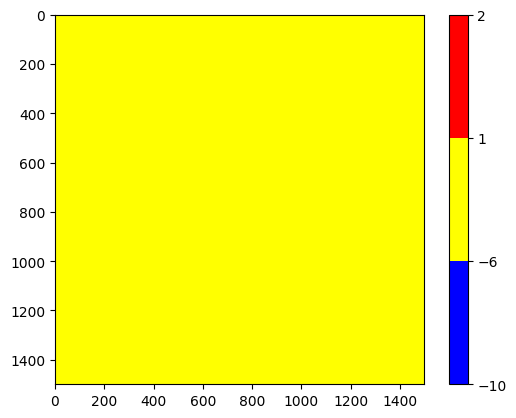

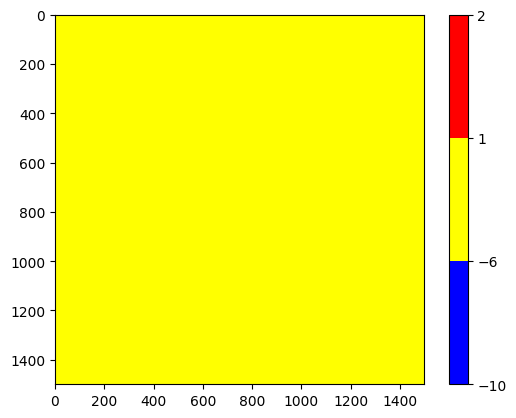

In [49]:
gridshow(coeffs_1)
gridshow(coeffs_2)

New axis extentions allow efficient vectorised computation of a grid of coefficients, but with such large grids of size (1000+, 1000+) it does not seem feasible to directly compute grids of exact coefficients.

# Mean capture efficiency approximation

## Coefficients

How does approximating the mean over per cell capture efficiencies by the mean capture efficiency affect B coefficient values?

$$ \frac{1}{n} \sum_{j = 1}^{n} B(..., \beta_{j}) \quad \stackrel{?}\approx \quad B(..., <\beta>) $$

In [50]:
true_values = []
approx_values = []
diff_values = []

for i in range(10000):

    # values
    x1_OB, x2_OB = rng.integers(0, 100, size=2)
    x1_OG, x2_OG = rng.integers(max(x1_OB, x2_OB), 1000, size=2)
    beta = rng.beta(1, 20, size=1000)
    beta[beta < 0.01] = 0.01

    # compute
    B_true = np.mean(scipy.stats.binom.pmf(x1_OB, x1_OG, beta) * scipy.stats.binom.pmf(x2_OB, x2_OG, beta))
    B_approx = scipy.stats.binom.pmf(x1_OB, x1_OG, np.mean(beta)) * scipy.stats.binom.pmf(x2_OB, x2_OG, np.mean(beta))

    true_values.append(B_true)
    approx_values.append(B_approx)
    diff_values.append(B_approx - B_true)

true_values = np.array(true_values)
approx_values = np.array(approx_values)
diff_values = np.array(diff_values)

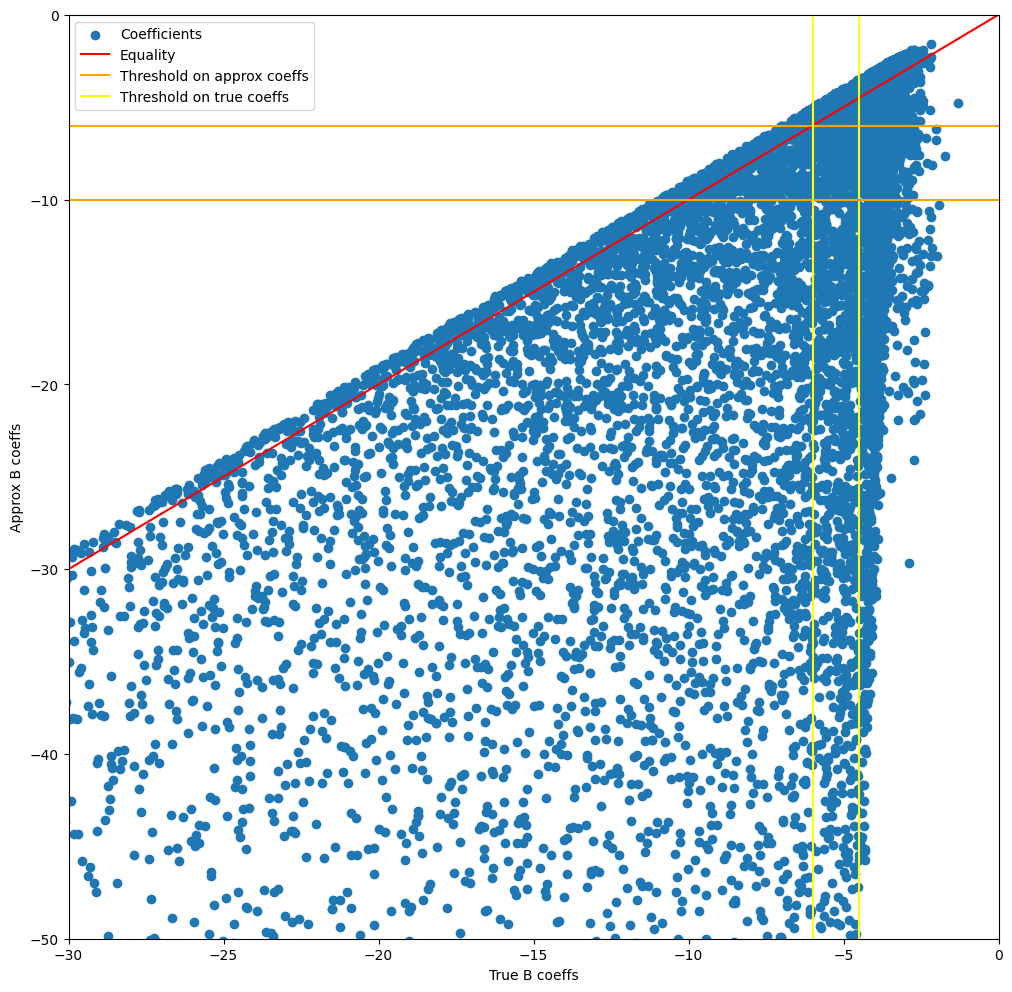

In [52]:
fig, axs = plt.subplots(figsize=(12, 12))
axs.scatter(
    np.log10(true_values),
    np.log10(approx_values),
    label="Coefficients"
)
axs.set_xlabel("True B coeffs")
axs.set_ylabel("Approx B coeffs")
axs.plot([0, -30], [0, -30], color="red", label="Equality")
axs.axhline(-6, color="orange", label="Threshold on approx coeffs")
axs.axvline(-4.5, color="yellow", label="Threshold on true coeffs")
axs.axhline(-10, color="orange")
axs.axvline(-6, color="yellow")
axs.set_xlim(-30, 0)
axs.set_ylim(-50, 0)
axs.legend()
plt.show()

Overall the approximated coefficients are smaller than the true coefficients, and can be significantly smaller, showing that the approximation is poor and so will not be helpful.

e.g. a coefficient with true value of $10^{-5}$ could be approximated by values between $10^{-4}$ and $10^{-50}$ (or even lower) which would force a choice of less than that for a theshold on approx coefficients. But then we would accept coefficients with true values as low as $10^{-60}$...

Overall the approximation is not accurate enough to be useful

## Truncations

In [331]:
def Bm_exact(x_OB, x_OG, beta):
    return scipy.stats.binom.pmf(x_OB, x_OG, beta).astype(np.float32)

def B_exact(x1_OB, x2_OB, x1_OG, x2_OG, beta):
    # return np.mean(scipy.stats.binom.pmf(x1_OB, x1_OG, beta) * scipy.stats.binom.pmf(x2_OB, x2_OG, beta), axis=4)
    return np.mean(Bm_exact(x1_OB, x1_OG, beta) * Bm_exact(x2_OB, x2_OG, beta), axis=4)

def exact_grid():

    # size and cells
    M = 1500
    n = 200

    # capture efficiency vector
    rng = np.random.default_rng(2499)
    beta = rng.beta(1, 20, size=n)

    # observed state
    x1_OB, x2_OB = np.array([1]), np.array([1])

    # array of original states
    x1_OG = np.arange(M)
    x2_OG = np.arange(M)

    # compute coefficents over grid
    coeffs = B_exact(
        x1_OB[:, None, None, None, None],
        x2_OB[None, :, None, None, None],
        x1_OG[None, None, :, None, None],
        x2_OG[None, None, None, :, None],
        beta[None, None, None, None, :]
    )

    return coeffs

In [323]:
def B_approx(x1_OB, x2_OB, x1_OG, x2_OG, beta_mean):
    return scipy.stats.binom.pmf(x1_OB, x1_OG, beta_mean) * scipy.stats.binom.pmf(x2_OB, x2_OG, beta_mean)

def approx_grid():

    # size and cells
    M = 1500
    n = 200

    # capture efficiency vector
    rng = np.random.default_rng(2499)
    beta = rng.beta(1, 20, size=n)
    beta_mean = np.mean(beta).reshape(1,)

    # observed state
    x1_OB, x2_OB = np.array([1]), np.array([1])

    # array of original states
    x1_OG = np.arange(M)
    x2_OG = np.arange(M)

    # compute coefficents over grid
    coeffs = B_approx(
        x1_OB[:, None, None, None, None],
        x2_OB[None, :, None, None, None],
        x1_OG[None, None, :, None, None],
        x2_OG[None, None, None, :, None],
        beta_mean[None, None, None, None, :]
    )

    return coeffs

In [332]:
coeffs_exact = exact_grid()

In [333]:
coeffs_approx = approx_grid()

C:\Users\willi\AppData\Local\Temp\ipykernel_4776\2473611320.py:7: RuntimeWarning: divide by zero encountered in log
  grid = np.log(grid)


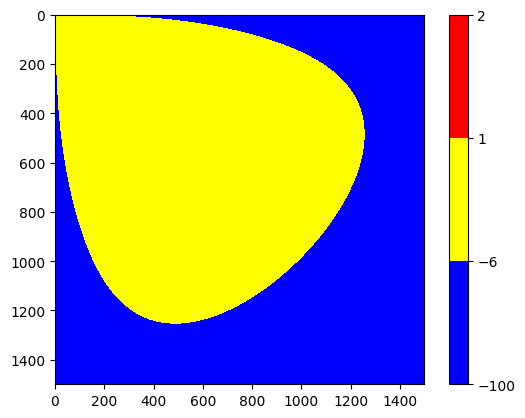

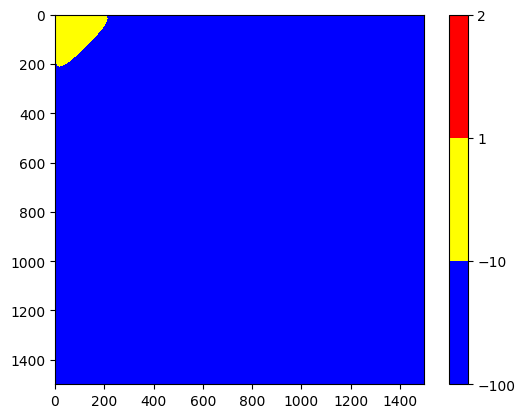

In [344]:
gridshow(coeffs_exact)
gridshow(coeffs_approx, thresh=-10)

Even with a reduced threshold of $10^{-10}$ or even $10^{-50}$ the approximated coefficients do not match the shape of the exact coefficients.

Again we see the approximation is not helpful

# Diagonal search

Existing code (for the case of a single capture efficiency) uses a vectorised diagonal search across the coefficient grid to identify the trunaction region.

Use newaxis vectorization to test performance with per cell capture efficiency

In [53]:
def Bm_diag(x_OB, x_OG, beta):
    return scipy.stats.binom.pmf(x_OB, x_OG, beta).astype(np.float32)

def B_diag(x1_OB, x2_OB, x1_OG, x2_OG, beta):
    return np.mean(Bm_diag(x1_OB, x1_OG, beta) * Bm_diag(x2_OB, x2_OG, beta), axis=1)

In [105]:
def diagonal_search(x1_OB, x2_OB, beta, thresh_OG=10**-6):
    '''
    Compute box truncation around states (x1_OG, x2_OG) which have
    B(x1_OB, x2_OB, x1_OG, x2_OG, beta) >= thresh_OG

    returns: m_OG, M_OG, n_OG, N_OG
    '''

    # modify arrays sizes for broadcasting over beta
    x1_OB_diag = np.array([x1_OB])[:, None]
    x2_OB_diag = np.array([x2_OB])[:, None]
    beta = beta[None, :]

    # setup flags
    trunc_start = False
    trunc_end = False
    m_OG, M_OG, n_OG, N_OG = np.inf, 0, np.inf, 0
    diag = 0
    while (not trunc_start) or (not trunc_end):

        # flag if at least one coeff > thresh in diagonal
        trunc_diag = False

        # diagonal from upper right to lower left
        x1_OG_diag = np.array([x1_OB + i for i in range(diag + 1)])
        x2_OG_diag = np.array([x2_OB + diag - i for i in range(diag + 1)])

        # compute coeffs
        coeffs = B_diag(
            x1_OB_diag,
            x2_OB_diag,
            x1_OG_diag[:, None],
            x2_OG_diag[:, None],
            beta
        )

        # find where above threshold
        idxs = np.argwhere(coeffs > thresh_OG).reshape(-1)

        # if any values above threshold
        if idxs.size > 0:

            # at least one coeff > thresh (overall)
            trunc_start = True

            # at least one coeff > thresh (in diag)
            trunc_diag = True

            # find states above threshold
            x1_states = x1_OG_diag[idxs]
            x2_states = x2_OG_diag[idxs]

            # find boundaries
            min_x1 = min(x1_states)
            min_x2 = min(x2_states)
            max_x1 = max(x1_states)
            max_x2 = max(x2_states)

            # update truncations
            if min_x1 < m_OG:
                m_OG = min_x1
            if min_x2 < n_OG:
                n_OG = min_x2
            if max_x1 > M_OG:
                M_OG = max_x1
            if max_x2 > N_OG:
                N_OG = max_x2

        # if NO coeff > thresh (in diag) AND at least one coeff > thresh (overall)
        if (not trunc_diag) and trunc_start:

            # end
            trunc_end = True

        # increment diagonal
        diag += 1

    truncation = {
        'min_x1': int(m_OG),
        'max_x1': int(M_OG),
        'min_x2': int(n_OG),
        'max_x2': int(N_OG),
        'label': "Diagonal search",
        'colour': "lime"
    }

    return truncation

In [138]:
def Bm_exact(x_OB, x_OG, beta):
    return scipy.stats.binom.pmf(x_OB, x_OG, beta).astype(np.float32)

def B_exact(x1_OB, x2_OB, x1_OG, x2_OG, beta):
    # return np.mean(scipy.stats.binom.pmf(x1_OB, x1_OG, beta) * scipy.stats.binom.pmf(x2_OB, x2_OG, beta), axis=4)
    return np.mean(Bm_exact(x1_OB, x1_OG, beta) * Bm_exact(x2_OB, x2_OG, beta), axis=4)

def grid(x1_OB, x2_OB, beta, M, N):

    # observed state
    x1_OB = np.array([x1_OB])
    x2_OB = np.array([x2_OB])

    # array of original states
    x1_OG = np.arange(M)
    x2_OG = np.arange(N)

    # compute coefficents over grid
    coeffs = B_exact(
        x1_OB[:, None, None, None, None],
        x2_OB[None, :, None, None, None],
        x1_OG[None, None, :, None, None],
        x2_OG[None, None, None, :, None],
        beta[None, None, None, None, :]
    )

    return coeffs

In [82]:
# observed state
x1_OB, x2_OB = 1, 1

# size
M = 1400
n = 1000

# sample capture
rng = np.random.default_rng(2499)
beta = rng.beta(1, 20, size=n)
beta[beta < 0.01] = 0.01

In [83]:
# compute exact grid
coeffs = grid(x1_OB, x2_OB, beta, M)

In [84]:
# compute truncation
truncation = diagonal_search(x1_OB, x2_OB, beta)

C:\Users\willi\AppData\Local\Temp\ipykernel_17372\2492096811.py:7: RuntimeWarning: divide by zero encountered in log10
  grid = np.log10(grid)


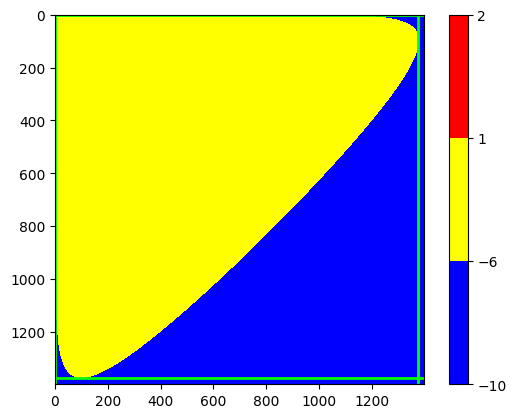

In [85]:
# display
gridshow(coeffs, truncation)

Exact coefficient computation (mean over per cell capture) in the diagonal approach is suprisingly fast, but scales poorly with large n (number of cells) and not feasible for large scale analysis (grid of observations)

# Marginal truncation approximation

In [182]:
def Bm_trunc(x_OB, x_OG, beta):
    return np.mean(scipy.stats.binom.pmf(x_OB, x_OG, beta))#.astype(np.float32)

def truncationm(x_OB, beta, threshM_OG=10**-6):

    # start at first non-zero coefficient
    x_OG = x_OB
    coeff = Bm_trunc(x_OB, x_OG, beta)

    # if not above threshold: increment until above
    while coeff < threshM_OG:

        # increment
        x_OG += 1

        # compute coeff
        coeff = Bm_trunc(x_OB, x_OG, beta)

    # store first state coeff >= thresh
    minM_OG = x_OG

    # increment until below threshold
    while coeff >= threshM_OG:

        # increment
        x_OG += 1

        # compute coeff
        coeff = Bm_trunc(x_OB, x_OG, beta)

    # store last state with coeff >= thresh (INCLUSIVE BOUND)
    maxM_OG = x_OG - 1

    return minM_OG, maxM_OG

In [183]:
def truncation_marginal(x1_OB, x2_OB, beta, thresh_OG=10**-6):

    min_x1, max_x1 = truncationm(x1_OB, beta, threshM_OG=thresh_OG)
    min_x2, max_x2 = truncationm(x2_OB, beta, threshM_OG=thresh_OG)

    truncation = {
        'min_x1': int(min_x1),
        'max_x1': int(max_x1),
        'min_x2': int(min_x2),
        'max_x2': int(max_x2),
        'label': "marginal",
        'colour': "black"
    }
    
    return truncation

In [150]:
# observed state
x1_OB, x2_OB = 5, 70 #rng.integers(10, 10, size=2)

# cells
n = 1

# sample capture
#rng = np.random.default_rng(2499)
#beta = rng.beta(1, 20, size=n)
#beta[beta < 0.01] = 0.01
beta = np.array([0.5 for j in range(n)])

In [151]:
# diagonal truncation
truncation_diag = diagonal_search(x1_OB, x2_OB, beta)

In [152]:
# marginal truncation
truncation_marg = truncation_marginal(x1_OB, x2_OB, beta)

In [157]:
# compute exact grid
coeffs = grid(x1_OB, x2_OB, beta, 50, 220)

C:\Users\willi\AppData\Local\Temp\ipykernel_17372\2386724955.py:7: RuntimeWarning: divide by zero encountered in log10
  grid = np.log10(grid)


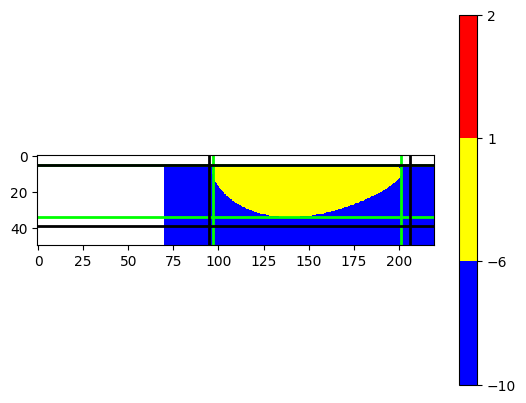

In [158]:
# display
gridshow(coeffs, [truncation_diag, truncation_marg])

Works very well: computing marginal truncations is fast (even with a simple for loop) and only needs to be done for a 1D range of observed counts (rather than for each pair). The truncation box produced is a superset of the true truncation box (provably contains truth) and is not significantly larger (see black vs green lines)

# Constraint construction

The marginal approximation gives an efficient method to compute truncation box bounds for each observed state.

However, we still need to efficiently construct the constraint which sums over the the coefficients inside the truncation

In [267]:
def Bm(x_OB, x_OG, beta):
    return scipy.stats.binom.pmf(x_OB, x_OG, beta)

def B(x1_OB, x2_OB, x1_OG, x2_OG, beta):
    return np.mean(Bm(x1_OB, x1_OG, beta) * Bm(x2_OB, x2_OG, beta))

In [251]:
def construct_constraints(x1_OB, x2_OB, beta, truncation, thresh_OG=10**-6):

    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as md:

            # marginal stationary distributions: original counts (size = largest original state + 1)
            p1 = md.addMVar(shape=(truncation['max_x1'] + 1), vtype=GRB.CONTINUOUS, name="p1", lb=0, ub=1)
            p2 = md.addMVar(shape=(truncation['max_x2'] + 1), vtype=GRB.CONTINUOUS, name="p2", lb=0, ub=1)

            # sum over truncation range (INCLUSIVE): drop terms with coefficients < thresh
            sum_expr = gp.quicksum([
                B(x1_OB, x2_OB, x1_OG, x2_OG, beta) * p1[x1_OG] * p2[x2_OG]
                for x1_OG in range(truncation['min_x1'], truncation['max_x1'] + 1)
                for x2_OG in range(truncation['min_x2'], truncation['max_x2'] + 1)
                if B(x1_OB, x2_OB, x1_OG, x2_OG, beta) >= thresh_OG
            ])

            md.addConstr(sum_expr >= 0.2, name=f"B lower bound")
            md.addConstr(sum_expr <= 0.8, name=f"B upper bound")

            md.write('base_mode.lp')

In [273]:
def Bm_constr(x_OB, x_OG, beta):
    return scipy.stats.binom.pmf(x_OB, x_OG, beta)#.astype(np.float32)

def B_constr(x1_OB, x2_OB, x1_OG, x2_OG, beta):
    return np.mean(Bm_constr(x1_OB, x1_OG, beta) * Bm_constr(x2_OB, x2_OG, beta), axis=4)

In [346]:
def vector_construct_constraints(x1_OB, x2_OB, beta, truncation, thresh_OG=10**-6):

    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as md:

            # marginal stationary distributions: original counts (size = largest original state + 1)
            p1 = md.addMVar(shape=(truncation['max_x1'] + 1), vtype=GRB.CONTINUOUS, name="p1", lb=0, ub=1)
            p2 = md.addMVar(shape=(truncation['max_x2'] + 1), vtype=GRB.CONTINUOUS, name="p2", lb=0, ub=1)

            # modify array shapes
            x1_OB = np.array([x1_OB])[:, None, None, None, None]
            x2_OB = np.array([x2_OB])[None, :, None, None, None]
            x1_OG = np.arange(truncation['min_x1'], truncation['max_x1'] + 1)[None, None, :, None, None]
            x2_OG = np.arange(truncation['min_x2'], truncation['max_x2'] + 1)[None, None, None, :, None]
            beta = beta[None, None, None, None, :]

            # compute coefficients in truncation box
            coeffs = B_constr(x1_OB, x2_OB, x1_OG, x2_OG, beta)

            # threshold
            coeffs[coeffs < thresh_OG] = 0.0

            # slice and outer product variables
            outer = p1[truncation['min_x1']: truncation['max_x1'] + 1, None] @ p2[None, truncation['min_x2']: truncation['max_x2'] + 1]

            # elementwise product to get sum terms
            prod_mat = coeffs * outer

            # construct sum
            sum_expr = prod_mat.sum()
            
            # form constraints
            md.addConstr(sum_expr >= 0.2, name=f"B lower bound")
            md.addConstr(sum_expr <= 0.8, name=f"B upper bound")

            md.write('vec_model.lp')

            return coeffs

In [348]:
# observed state
x1_OB, x2_OB = 0, 0

# sample capture
n = 100
beta_test = rng.beta(1, 20, size=n)
beta_test[beta_test < 0.01] = 0.01

# compute truncation
truncation_test = truncation_marginal(x1_OB, x2_OB, beta_test)

In [350]:
coeffs = vector_construct_constraints(x1_OB, x2_OB, beta_test, truncation_test)

Set parameter Username
Set parameter WLSAccessID
Set parameter WLSSecret


Set parameter LicenseID to value 2587777
Academic license 2587777 - for non-commercial use only - registered to wj___@ic.ac.uk


In [351]:
coeffs.shape

(1, 1, 1184, 1184)

In [344]:
construct_constraints(x1_OB, x2_OB, beta_test, truncation_test)

Set parameter Username
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2587777
Academic license 2587777 - for non-commercial use only - registered to wj___@ic.ac.uk


In [240]:
# observed state
x1_OB, x2_OB = 5, 5 #rng.integers(10, 10, size=2)

# cells
n = 100

# sample capture
#rng = np.random.default_rng(2499)
#beta = rng.beta(1, 20, size=n)
#beta[beta < 0.01] = 0.01
beta = np.array([0.5 for j in range(n)])

In [241]:
# marginal truncation
truncation_marg = truncation_marginal(x1_OB, x2_OB, beta)

In [242]:
# compute exact grid
coeffs = grid(x1_OB, x2_OB, beta, 50, 50)

C:\Users\willi\AppData\Local\Temp\ipykernel_17372\2386724955.py:7: RuntimeWarning: divide by zero encountered in log10
  grid = np.log10(grid)


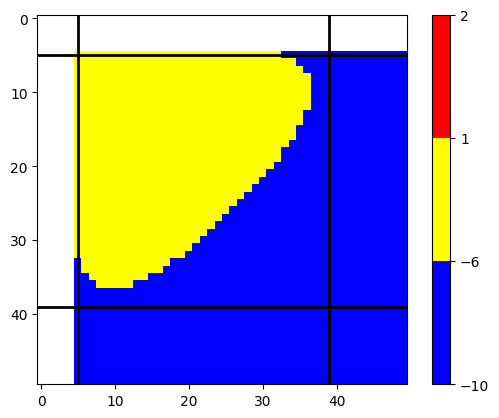

In [243]:
# display
gridshow(coeffs, [truncation_marg])

In [244]:
construct_constraints(x1_OB, x2_OB, beta, truncation_marg)

Set parameter Username
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2587777
Academic license 2587777 - for non-commercial use only - registered to wj___@ic.ac.uk


In [192]:
construct_constraints(x1_OB, x2_OB, beta, truncation_marg)

Set parameter Username
Set parameter WLSAccessID
Set parameter WLSSecret


Set parameter LicenseID to value 2587777
Academic license 2587777 - for non-commercial use only - registered to wj___@ic.ac.uk
